<a href="https://colab.research.google.com/github/schedldave/cv2022/blob/main/HW04_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Homework 04 - Autoencoder Compression

Contact: David C. Schedl (david.schedl@fh-hagenberg.at)

Note: this is the starter pack for the **Computer Vision** homework. You do not need to use this template!

## Task:
Implement your image compression algorithm by ~~exploiting the frequency domain~~ using auto encoders. 

An autoencoder is a neural network that learns efficient codings of unlabeled data (so it uses unsupervised learning). If the encoding is much smaller than the initial data you can think of the algorithm as compression.
That's what we want to do in this task!

Implement an autoencoder that compresses images. The dataset that you train it with and the resolution is up to you. 
Evaluate how small the encoding can get before the image quality gets pretty bad?

Analyze your algorithm on a set of images and evaluate your results concerning quality (e.g., MSE) and size reduction achieved (how many bits could be saved?). Ignore the memory needed for storing the network weights. 
Are there available parameters and how can you tune them?

Ideally you use (a large) set of different evaluation images (e.g., showing artificial content, buildings, nature, animals, objects, colors, …). Make sure that the same images are not in your training set.

*Hint:* Work with low-res images and small networks to speed up computation and avoid huge storage requirements.


**Further comments/hints:**

*   You do not need to come up with a super network architecture! It is mostly about getting into the topic.
*   It is up to you if you want to use a CNN or a classical NN with MLPs (dense layers). 
*   Think about the problem, solve it, and critically evaluate your solution.
*   For this exercise, it makes sense to compare it to your results of HW01.
*   Summarize your ideas and findings in the report. 



**Have fun!** 😸


## Initialization

As always let's import useful libraries, first. 
This notebook works with TensorFlow and is designed to run in a Colab Environment. 
Getting everything running locally might take some time.



In [1]:
%%capture 
# use %% capture suppress any output

# make sure to use tensorflow 2.x
%tensorflow_version 2.x

# load the TensorBoard notebook extension to display training results later
%load_ext tensorboard

import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.losses as losses
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, MaxPooling2D, 
                                     Conv2DTranspose, Reshape, Input)

from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

from __future__ import absolute_import, division, print_function, unicode_literals

def MSE(A,B):
  """compute the mean squared error (MSE) between numpy array A and B
  """
  return ((A - B)**2).mean(axis=None)


## Example Dataset: CIFAR 10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It was originally used for Machine Learning, but we can use it for our compression experiments.
For details, see [this website](https://www.cs.toronto.edu/~kriz/cifar.html)!

The dataset is readily available as TensorFlow/Keras dataset. 
In HW01 we used a different way to load the data (without TensorFlow).

**Note: you do not need to use CIFAR-10! Any other dataset is fine.** 

In [2]:
(x_train, _), (x_test, _) = datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


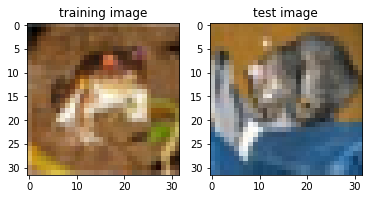

In [3]:
# display one training and one test image

train_image = x_train[0]
test_image = x_test[0]

plt.subplot(1,2,1), plt.imshow(train_image), plt.title('training image')
plt.subplot(1,2,2), plt.imshow(test_image), plt.title('test image')
plt.show()


## Example AutoEncoder with Multi-Layer Perceptrons (Dense layers)

An implementation of an MLP autoencoder which encodes images to a latent vector. 
For further details see this [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder).


In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, image_shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      Flatten(),
      Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      Dense(np.prod(image_shape), activation='sigmoid'),
      Reshape(image_shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

latent_dim = 64 
image_shape = x_train[0].shape
autoencoder = Autoencoder(latent_dim, image_shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.build(x_test.shape)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10000, 64)               196672    
                                                                 
 sequential_1 (Sequential)   (10000, 32, 32, 3)        199680    
                                                                 
Total params: 396,352
Trainable params: 396,352
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Training Preparation (if you want to use TensorBoard)

# Place the logs in a timestamped subdirectory
# This allows to easy select different training runs
# In order not to overwrite some data, it is useful to have a name with a timestamp
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Specify the callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# tf.keras.callback.TensorBoard ensures that logs are created and stored
# We need to pass callback object to the fit method
# The way to do this is by passing the list of callback objects, which is in our case just one

In [ ]:
%tensorboard --logdir logs/fit
# open the TensorBoard here!

### Training

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback],
                verbose=True)

Epoch 1/10
1563/1563 [==============================] - 8s 3ms/step - loss: 0.0385 - val_loss: 0.0337
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0317 - val_loss: 0.0298
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0293 - val_loss: 0.0288
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0287 - val_loss: 0.0286
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0287 - val_loss: 0.0287
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0286 - val_loss: 0.0286
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0286 - val_loss: 0.0286
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0286 - val_loss: 0.0285
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0286 - val_loss: 0.0285
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.028

### Encoding / Decoding

In [8]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape) # every encoded image is represented by 64 values
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

(10000, 64)


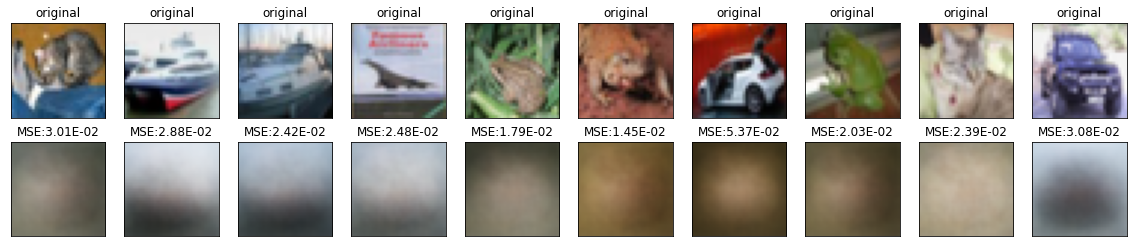

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  mse = MSE(x_test[i], decoded_imgs[i])

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title(f"MSE:{mse:.2E}")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Example AEs with Convolutional Layers

Below you will find two variants of autoencoders that use convolutions to downsample and transposed convolutions to upsample. 

The second variant uses dense layers to further downsample. Note that dense layers result in a huge number of parameters!

In [10]:
# a convolutional auto encoder with convolutional and transposed convolutional layers 
class ConvAutoencoderV1(Model):
  def __init__(self, latent_dim, image_shape):
    super(ConvAutoencoderV1, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=image_shape),
      Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), # downsample x2
      Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),  # downsample x2
      Conv2D(4, (3, 3), activation='relu', padding='same', strides=2),  # downsample x2
      # 4x4x4 = 64
    ])

    latent_img_shape = (8,int(image_shape[0]/4),int(image_shape[1]/4))

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(image_shape[2], kernel_size=(3, 3), activation='sigmoid', padding='same') # back to color
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

latent_dim = 64 
image_shape = x_train[0].shape
autoencoder = ConvAutoencoderV1(latent_dim, image_shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.build(x_test.shape)
autoencoder.summary()

Model: "conv_autoencoder_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4, 4, 4)           1900      
                                                                 
 sequential_3 (Sequential)   (10000, 32, 32, 3)        2047      
                                                                 
Total params: 3,947
Trainable params: 3,947
Non-trainable params: 0
_________________________________________________________________


In [11]:
# a convolutional auto encoder with additional dense layers 
# Note that this has a lot more parameters!

class ConvAutoencoderV2(Model):
  def __init__(self, latent_dim, image_shape):
    super(ConvAutoencoderV2, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=image_shape),
      Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), # downsample x2
      Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),  # downsample x2
      Flatten(), # 8x8x8 = 512
      Dense(latent_dim, activation='relu')
    ])

    latent_img_shape = (8,int(image_shape[0]/4),int(image_shape[1]/4))

    self.decoder = tf.keras.Sequential([
      Input(shape=(latent_dim,)),
      Dense(np.prod(latent_img_shape)),
      Reshape(latent_img_shape),
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(image_shape[2], kernel_size=(3, 3), activation='sigmoid', padding='same') # back to color
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

latent_dim = 64 
image_shape = x_train[0].shape
autoencoder = ConvAutoencoderV2(latent_dim, image_shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.build(x_test.shape)
autoencoder.summary()

Model: "conv_autoencoder_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64)                34440     
                                                                 
 sequential_5 (Sequential)   (None, 32, 32, 3)         35467     
                                                                 
Total params: 69,907
Trainable params: 69,907
Non-trainable params: 0
_________________________________________________________________
